# Оглавление
1. [Исследовательский анализ данных](#Шаг_1)
2. [Обучение модели](#Шаг_2)
3. [Анализ обученной модели](#Шаг_3)

<a name="Шаг_1"></a>

# 1. Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout, AvgPool2D, GlobalAveragePooling2D

In [2]:
datagen = ImageDataGenerator(rescale=1./255)

In [3]:
data = pd.read_csv('/datasets/faces/labels.csv')

---
#### Размер выборки
---

In [4]:
data.head(3)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


Два столбца (фото, возраст)

In [5]:
data.shape

(7591, 2)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков нет. тип данных нормально

In [7]:
data.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [8]:
data[data.real_age == 1]

,file_name,real_age
13,000013.jpg,1
21,000021.jpg,1
30,000030.jpg,1
40,000040.jpg,1
53,000053.jpg,1
...,...,...
7542,007564.jpg,1
7546,007568.jpg,1
7574,007596.jpg,1
7577,007599.jpg,1


In [40]:
data[data.real_age == 100]

,file_name,real_age
2661,002661.jpg,100


Проверю пики

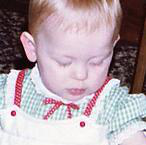

In [41]:
Image.open(r'/datasets/faces/final_files/000053.jpg')

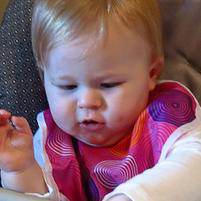

In [42]:
Image.open(r'/datasets/faces/final_files/007596.jpg')

С возрастом 1 год, не ошибка

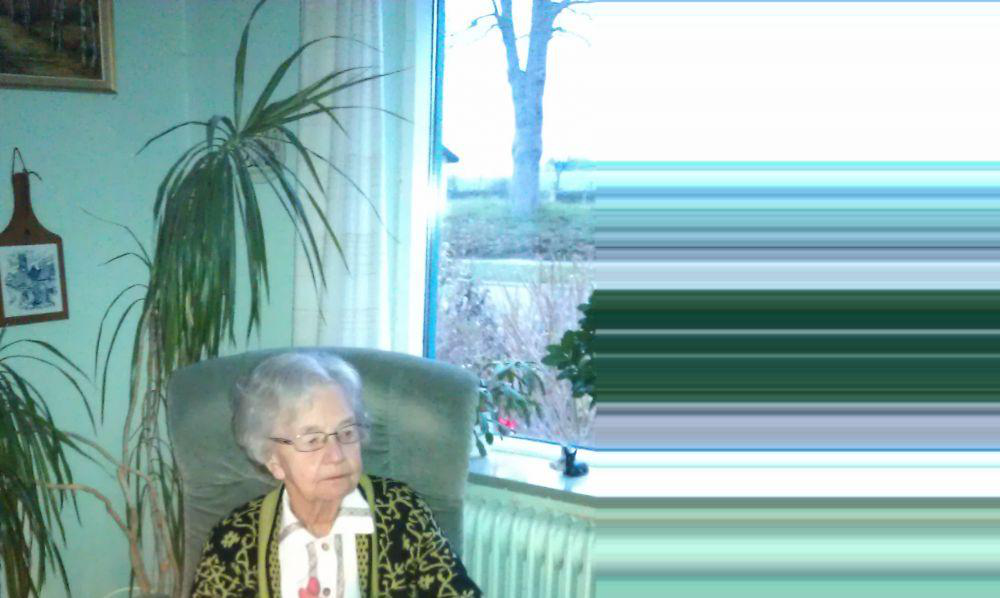

In [43]:
Image.open(r'/datasets/faces/final_files/002661.jpg')

Похоже на 100 лет

---
#### График распределения возраста
---

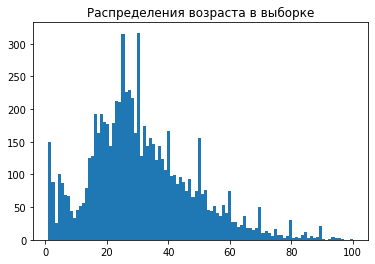

In [44]:
plt.hist(data.real_age, bins=100)
plt.title('Распределения возраста в выборке')
plt.show()

Основное количество фотографий принадлежит лицам между 20 и 40 годами. Соц сети и тд. Считаю самой активной частью всей аудитории пользователей производящих фотографии и активно учавствующий в различных мероприятиях.
Отдельно стоит отметить группу детей возраста от 1 года до 10 лет. Люди любят фотографировать своих детей.

---
#### 10–15 фотографий
---

In [45]:
generator = datagen.flow_from_dataframe(
        dataframe = data,
        directory = '/datasets/faces/final_files/',
        x_col = 'file_name',
        y_col ='real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        seed=12345)

Found 7591 validated image filenames.


In [46]:
features, target = next(generator)

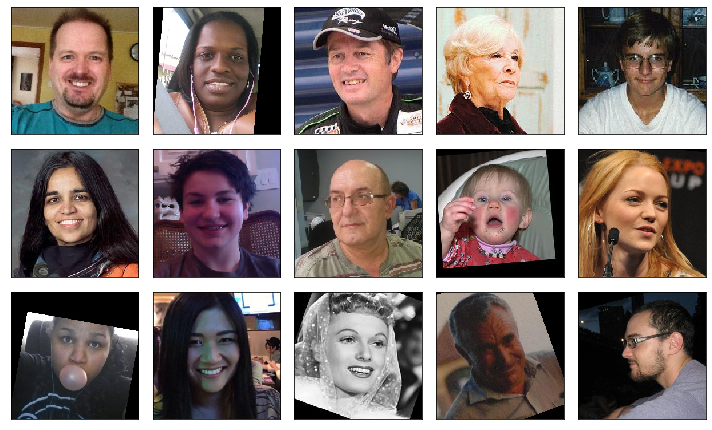

In [47]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout() 

___
Лучше всего модель будет различать людей возраста 20 - 40. Считаю что детей и людей старшего возраста, предсказания будут хуже.
___

<a name="Шаг_2"></a>

# 2. Обучение модели

```python

def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(
        rotation_range=90,
        validation_split = 0.25,
        rescale=1./255,
        horizontal_flip = True,
        vertical_flip=True, 
        width_shift_range = 0.2,  
        height_shift_range = 0.2
    )
    train_datage_flow = train_datagen.flow_from_dataframe(
        
        dataframe = labels,
        directory = '/datasets/faces/final_files/',
        x_col = 'file_name',
        y_col ='real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        seed=12345)
    return train_datage_flow 

def load_test(path):
    labels_test = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(
        rotation_range=90,
        rescale=1./255,
        horizontal_flip = True,
        vertical_flip=True, 
        width_shift_range = 0.2,  
        height_shift_range = 0.2
    )
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels_test,
        directory = '/datasets/faces/final_files/',
        x_col = 'file_name',
        y_col ='real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.00001), metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)   
 
    model.fit(train_data,validation_data=train_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model


```

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 238 steps, validate for 238 steps
Epoch 1/10
2020-10-14 09:57:20.473757: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-10-14 09:57:24.377050: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
238/238 - 330s - loss: 771.9167 - mae: 22.6621 - val_loss: 569.5812 - val_mae: 20.4653
Epoch 2/10
238/238 - 246s - loss: 235.8139 - mae: 11.6706 - val_loss: 345.5220 - val_mae: 14.1644
Epoch 3/10
238/238 - 245s - loss: 159.4644 - mae: 9.6012 - val_loss: 336.7207 - val_mae: 13.7503
Epoch 4/10
238/238 - 245s - loss: 133.1865 - mae: 8.7760 - val_loss: 140.6754 - val_mae: 9.1182
Epoch 5/10
238/238 - 244s - loss: 122.5093 - mae: 8.4740 - val_loss: 109.2891 - val_mae: 7.9825
Epoch 6/10
238/238 - 243s - loss: 113.2020 - mae: 8.1056 - val_loss: 122.5544 - val_mae: 8.3566
Epoch 7/10
238/238 - 244s - loss: 106.9985 - mae: 7.8808 - val_loss: 99.2661 - val_mae: 7.6611
Epoch 8/10
238/238 - 243s - loss: 101.6638 - mae: 7.6574 - val_loss: 103.8024 - val_mae: 7.6822
Epoch 9/10
238/238 - 242s - loss: 97.2585 - mae: 7.5175 - val_loss: 87.2285 - val_mae: 7.1717
Epoch 10/10
238/238 - 244s - loss: 93.6609 - mae: 7.3618 - val_loss: 92.2984 - val_mae: 7.3463
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
238/238 - 121s - loss: 92.0855 - mae: 7.2988
Test MAE: 7.2988



```

<a name="Шаг_3"></a>

# 3. Анализ обученной модели

Настройки ImageDataGenerator - применял однинаковые в функциях load_train и load_test (за исключением validstion_split). Без применения параметра rotation_range в настройках ImageDataGenerator, метрика MAE не опусказась ниже 20, как на valid так и на test. optimizer в функции def create_model использовал Adam, learning_rateдостаточно значение 0.00001. Меньше значение протестировать не смог, метрика MAE опустилась ниже 8, и тренажер зачел модель. Проверил утверждение из тренажера, что с функцией потерь MSE обучение быстрее.
В конечном итоге считаю, что ошибка в 7 - 8 лет достаточо велика. Хотелось бы увеличить количество фотографий людей раннего и позднего возрастов. Так как именно для этой категории людей такая ошибка чрезмерна. Либо делить датасет по категориям возрастов и обучать отдельно модель для каждой категории. И дополнительно классифицировать людей по возрастам, где ошибка вызывает или не вызывает сильные удивления. 